In [1]:
import pickle 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timezone
import logging
logging.basicConfig(filename='logs.log', level=logging.INFO)
from collections import defaultdict

In [2]:
G = nx.read_edgelist('final.edgelist',create_using=nx.DiGraph)

In [3]:
G.number_of_nodes(), G.number_of_edges()

(3409, 13504)

In [ ]:
data['806344552718045184']

## Check opinions

In [4]:
import json
 
# Opening JSON file
with open('vax_final.json') as json_file:
    data = json.load(json_file)

In [5]:
ttl_tweets = 0
for i in data:
    ttl_tweets += len(data[i])
print(ttl_tweets)

60538


## Central node, a doctor against vax.

In [7]:
example_user = data['806344552718045184']
ex_tweet = example_user[0]['tweet_id']
ex_tweet

1513277342294196232

In [6]:
ex_tweet=='1513277342294196232'

False

# Setup accounts for twitter crawler and OpenAI

In [6]:
from twscrape import API, gather
from twscrape.logger import set_log_level

import openai

In [ ]:
# twscrape in add_account, add your twitter account info (username, pwd, email, emailpwd) 
api = API()
await api.pool.add_account()
await api.pool.login_all()

openai.api_key = "ur api key here"

# Data collection

## collect user name - ID mapping

In [ ]:
user_name_id_dict = {}

In [ ]:

for user_id in G.nodes():
#     if user_id in 
    u = await api.user_by_id(int(user_id))
    try:
        user_name_id_dict[u.username] = user_id
    except:
        continue

In [66]:
pickle.dump(user_name_id_dict, open("user_id_dict.pkl",'wb'))

In [65]:
len(user_name_id_dict), G.number_of_nodes()

(2861, 3409)

In [112]:
1462222331334610944 in user_name_id_dict.values()

False

In [9]:
tweet_content = {}
# f = open('tweet_id_content_rate.txt','w')
# f.close()

In [10]:
f = open('tweet_id_content_rate.txt','r')
for line in f:
    if line.startswith("tweetID:"):
        tweet_content[int(line.split(",")[0].split(":")[1])] = line.split(",")[1]
f.close()

# tweet_content = {}
history = set()
f = open('tweet_id_content_rate_history.txt','r')
for line in f:
    try:
        tweet_id = int(line.split(',')[0])
    except:
        continue
    history.add(tweet_id)
f.close()

deleted_tweets = set()
f = open('deleted_tweets.txt','r')
for line in f:
    deleted_tweets.add(int(line.strip()))
f.close()

In [22]:
print(len(tweet_content), len(history), len(deleted_tweets))

43079 1654 15477


In [13]:
logging.info(len(tweet_content))

In [12]:
from tqdm import tqdm
import time

In [13]:
response_backup = {}

In [ ]:
sys_msg = f"""return only integer rate for the following tweet. The rate represents its opinion towards 
            covid vaccination with an integer between 0 to 10, with 10 being very positive 
            and support vaccination, 0 being very negative and skeptical about it, and 5 
            being completely neutral. Covid vaccination is also called vax."""

msgs = [{"role":'system', "content":sys_msg}]
m = 0
t_ids = []
for i in tqdm(G.nodes()):
    user_data = data[i]
    for each in user_data:
        tweet_id = each['tweet_id']
        if tweet_id in tweet_content or tweet_id in history or tweet_id in deleted_tweets:
            continue
        rawContent = await api.tweet_details(tweet_id)
        if rawContent is None:
            deleted_tweets.add(tweet_id)
            logging.info(str(tweet_id) + " give none")
            f = open('deleted_tweets.txt','a')
            f.write(str(tweet_id)+"\n")
            f.close()
            continue
        t_ids.append(tweet_id)
        tweet_content[tweet_id] = [rawContent.rawContent]
        msgs.append({"role":"user","content": rawContent.rawContent})
#         if len(msgs)>10:
        while True:
            cnt = 0
            try:
                response = openai.ChatCompletion.create(
                    model="gpt-3.5-turbo",  # You can use other engines as well
                    messages=msgs,
                    temperature=0.2
                )
            except:
                cnt += 1
                if cnt>=4:
                    logging.info(tweet_id, " message causing API error")
                    logging.info("break after 3 attempts")
                    break
                time.sleep(8*60)
                continue
            response_backup[tweet_id] = response
            print(response['choices'][0]['message']['content'])
#             for idx in range(len(t_ids)):
#                 tweet_id = t_ids[idx]
            rate = response['choices'][0]['message']['content'].strip()
            tweet_content[tweet_id].append(rate)
            f = open('tweet_id_content_rate.txt','a')
            f.write("tweetID:"+str(tweet_id)+','+tweet_content[tweet_id][1]+','+tweet_content[tweet_id][0]+'\n')
            f.close()
#             t_ids = []
            msgs = [{"role":'system', "content":sys_msg}]
            break
       

In [54]:
f = open('tweet_id_content_rate.txt','a')
f.write("tweetID:"+str(tweet_id)+'\n')
f.close()

## remove invalid labels and store final result

In [33]:
def has_numbers(inputString):
    cnt = 0
    res = -1
    for char in inputString:
        if char.isdigit():
            cnt += 1
            res = int(char)
        if cnt==2:
            if res==1 and char=='0':
                res = 10
                cnt = 1
            else:
                return -1
    return res

final_opinion_dict = {}
for i in tweet_content:
    try:
        final_opinion_dict[i] = int(tweet_content[i])
    except:
        check_res = has_numbers(tweet_content[i])
        if check_res==-1:
            continue
        else:
            final_opinion_dict[i] = check_res
len(tweet_content), len(final_opinion_dict)

(43079, 37841)

In [34]:
f = open('tweet_id_content_rate_history.txt','r')
prev_line = ''
prev_id = -1
for line in f:
    try:
        tweet_id = int(line.split(',')[0])
        final_opinion_dict[prev_id] = int(prev_line.split(',')[-1])
        prev_line = line
        prev_id = tweet_id
    except:
        prev_line = line
        continue

In [35]:
len(final_opinion_dict)

39488

In [38]:
pickle.dump(final_opinion_dict, open("vax_gpt_labels.pkl","wb"))

(array([24320.,    82.,  5957.,   255.,   994.,  4767.,   322.,  1128.,
         1397.,   266.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

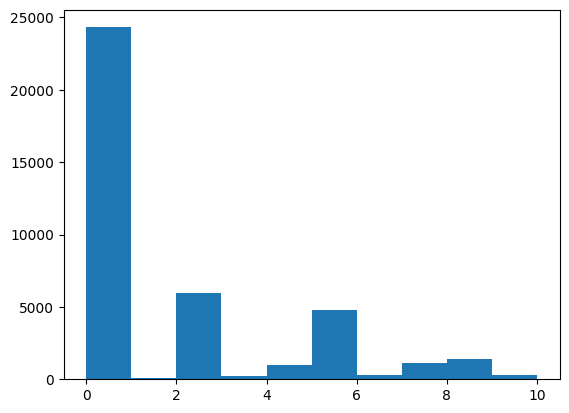

In [37]:
plt.hist(list(final_opinion_dict.values()))

## construct mention relations 

In [68]:
len(response_backup)

24686

In [115]:
tid_uid_map = {}
for user in data:
    for it in data[user]:
        tid_uid_map[it["tweet_id"]] = int(user)

In [117]:
f = open('tweet_id_content_rate_history.txt','r')
tid_mentionID_dict = {}
prev_line = ''
prev_id = -1
tmp = []
for line in f:
    cur = []
    if "@" in line:
        for sub in line.split("@"):
            pos_name = sub.split(" ")[0]
            if pos_name in user_name_id_dict:
                cur.append(int(user_name_id_dict[pos_name]))
    try:
        tweet_id = int(line.split(',')[0])
        if len(tmp)>0:
            tid_mentionID_dict[tid_uid_map[prev_id]] = tmp
        tmp = cur
#         final_opinion_dict[prev_id] = int(prev_line.split(',')[-1])
        prev_line = line
        prev_id = tweet_id
    except:
        prev_line = line
        tmp = tmp+cur
        continue

In [118]:
f = open('tweet_id_content_rate.txt','r')
prev_line = ''
prev_id = -1
tmp = []
for line in f:
    cur = []
    if "@" in line:
        for sub in line.split("@"):
            pos_name = sub.split(" ")[0]
            if pos_name in user_name_id_dict:
                cur.append(int(user_name_id_dict[pos_name]))
    if line.startswith("tweetID"):
        tweet_id = int(line.split(',')[0].split(":")[1])
        if len(tmp)>0:
            tid_mentionID_dict[tid_uid_map[prev_id]] = tmp
        tmp = cur
        prev_line = line
        prev_id = tweet_id
    else:
        prev_line = line
        tmp = tmp+cur
        continue

In [119]:
pickle.dump(tid_mentionID_dict, open("vax_mention_tid_dict.pkl","wb"))

In [120]:
s = 0
u_set2 = set()
for i in tid_mentionID_dict:
    u_set2.add(int(i))
    for j in tid_mentionID_dict[i]:
        u_set2.add(int(j))
    s+= (len(tid_mentionID_dict[i]))
print(s, len(u_set2))

380 430


In [121]:
mentions = {}
for i in G.nodes():
    user_data = data[i]
    for each in user_data:
        tweet_id = each['tweet_id']
        if tweet_id in tid_mentionID_dict:
            if i in mentions:
                mentions[i].append(tid_mentionID_dict[tweet_id])
            else:
                mentions[i] = [tid_mentionID_dict[tweet_id]]
            
print(len(mentions))

0


In [128]:
len(u_set|u_set2)

648

In [124]:
with open('ukrainewar_final.json') as json_file:
    data = json.load(json_file)
    
tid_uid_map = {}
for user in data:
    for it in data[user]:
        tid_uid_map[it["tweet_id"]] = int(user)

In [125]:
f = open('tweet_id_content_rate_war.txt','r')
tid_mentionID_dict = {}
prev_line = ''
prev_id = -1
tmp = []
for line in f:
    cur = []
    if "@" in line:
        for sub in line.split("@"):
            pos_name = sub.split(" ")[0]
            if pos_name in user_name_id_dict:
                cur.append(user_name_id_dict[pos_name])
    if line.startswith("tweetID"):
        tweet_id = int(line.split(',')[0].split(":")[1])
        if len(tmp)>0:
            tid_mentionID_dict[tid_uid_map[prev_id]] = tmp
        tmp = cur
        prev_line = line
        prev_id = tweet_id
    else:
        prev_line = line
        tmp = tmp+cur
        continue

In [126]:
pickle.dump(tid_mentionID_dict, open("war_mention_tid_dict.pkl","wb"))

In [127]:
s = 0
u_set = set()
for i in tid_mentionID_dict:
    u_set.add(int(i))
    for j in tid_mentionID_dict[i]:
        u_set.add(int(j))
    s+= (len(tid_mentionID_dict[i]))
print(s, len(u_set))

288 343


In [97]:
mentions = {}
for i in G.nodes():
    user_data = data[i]
    for each in user_data:
        tweet_id = each['tweet_id']
        if tweet_id in tid_mentionID_dict:
            if i in mentions:
                mentions[i].append(tid_mentionID_dict[tweet_id])
            else:
                mentions[i] = [tid_mentionID_dict[tweet_id]]
            
print(len(mentions))

5
